In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import spyrit.core.torch as st

In [2]:
def generate_heterogeneous_data(mu_2,n, p, imbalance_factor=10, random_seed=42):
    np.random.seed(random_seed)
    
    # Parameters for two components
    # Component 1: Standard variance, centered at 0
    mu1 = np.zeros(p)
    sigma1 = np.eye(p)
    
    # Component 2: High variance, shifted mean and scaled covariance
    mu2 = np.ones(p) * mu_2  # Shifted mean
    sigma2 = np.eye(p) * imbalance_factor  # High variance component
    
    # Define mixing proportions (say, 80% from component 1 and 20% from component 2)
    weights = [0.8, 0.2]
    
    # Generate data for each component
    n1 = int(n * weights[0])
    n2 = n - n1
    X1 = np.random.multivariate_normal(mu1, sigma1, size=n1)
    X2 = np.random.multivariate_normal(mu2, sigma2, size=n2)
    
    # Combine the data
    X = np.vstack((X1, X2))
    np.random.shuffle(X)
    epsilon = np.random.normal(0, 1, size=n)
    beta = np.random.normal(0, 1, size=p)
    Y = np.dot(X, beta) + epsilon
    return X, Y, beta

In [3]:
# Step 1: Hadamard rademacher randomization
def fhm(X,Y):
    # Generate a diagonal matrix of -1 or 1 with 0.5 probability
    diag_matrix = np.diag(np.random.choice([-1, 1], size=X.shape[0]))
    signs = diag_matrix
    # Multiply each row of X and Y by the corresponding sign
    result_X = np.dot(signs, X)
    result_Y = np.dot(signs, Y)
    # Convert to PyTorch tensor with float64
    tensor_matrix_X = torch.tensor(result_X, dtype=torch.float64)
    tensor_matrix_Y = torch.tensor(result_Y, dtype=torch.float64)
    # Apply FWHT
    tensor_matrix_X = st.fwht(tensor_matrix_X.T).T
    tensor_matrix_Y = st.fwht(tensor_matrix_Y)
    # Convert back to numpy array
    X = tensor_matrix_X.numpy() / np.sqrt(X.shape[0])
    Y = tensor_matrix_Y.numpy() / np.sqrt(Y.shape[0])
    return X, Y

In [4]:
def partition_matrix(X,Y,k):
    """
    Partition the rows of matrix X across k machines uniformly with equal probability.
    Each machine will receive a sub-matrix of X and the corresponding sub-vector of Y.

    Parameters:
    X (numpy.ndarray): The input matrix to be partitioned (n rows, m columns).
    Y (numpy.ndarray): The output vector to be partitioned (n rows, 1 column).
    k (int): The number of machines.

    Returns:
    list of numpy.ndarray: A list of sub-matrices, each assigned to a machine.
    """
    # Get the number of rows in the matrix
    n = X.shape[0]
    
    # Create an array of row indices (0 to n-1)
    indices = np.arange(n)
    
    # Shuffle the indices randomly to ensure each row has equal probability
    np.random.shuffle(indices)
    
    # Calculate the base size of each partition and the remainder
    part_size = n // k  # Base number of rows per machine
    remainder = n % k   # Extra rows to distribute
    
    # Split the indices into k parts
    parts = []
    start = 0
    for i in range(k):
        # The first 'remainder' machines get one extra row
        end = start + part_size + (1 if i < remainder else 0)
        parts.append(indices[start:end])
        start = end
    
    # Create sub-matrices for each machine using the partitioned indices
    sub_matrices = [X[part] for part in parts]
    sub_matrices_Y = [Y[part] for part in parts]
    
    return sub_matrices, sub_matrices_Y

In [5]:
#Expected Efficiency,DELTA^2 = 1
def MSE(X,A,delta = 1):
    return (delta**2)*np.trace(np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(A.T,A)))

In [6]:
def average_MSE_expectation(X,Y,k,delta = 1):
    sub_matrices,sub_target = partition_matrix(X,Y,k)
    mse_pre = 0
    for i in range(k):
        X_i = sub_matrices[i]
        Y_i = sub_target[i]
        X_i = np.array(X_i)
        Y_i = np.array(Y_i)
        MSE_gained = MSE(X_i,np.eye(X_i.shape[1]),delta)
        MSE_gained = MSE_gained * ((1/k)**2)
        mse_pre += MSE_gained
    return mse_pre
def Relative_Efficiency(MSE_ols,X,Y,k,delta=1):
    mse = average_MSE_expectation(X,Y,k,delta)
    mse = MSE_ols/mse
    mse = round(mse,4)
    return mse

In [7]:
def relative_efficiency_plot_mu(mu_2, number, MSE_ols, X, Y, X_hadamard, Y_hadamard):    
    # Relative Efficiency Plot
    Expected_E_US = []
    Expected_E_HR = []
    for i in range(number):
        num = i + 1
        E_us = Relative_Efficiency(MSE_ols, X, Y, num, delta=1)
        Expected_E_US.append(E_us)
        E_hr = Relative_Efficiency(MSE_ols, X_hadamard, Y_hadamard, num, delta=1)
        Expected_E_HR.append(E_hr)
    Expected_E_US = np.array(Expected_E_US)
    Expected_E_HR = np.array(Expected_E_HR)
    
    # Plot lines and scatter points
    plt.plot(range(1, number+1), Expected_E_US, label='E for US', linestyle='-.', linewidth=1)
    plt.scatter(range(1, number+1), Expected_E_US, marker="o", c="blue", s=8)
    plt.plot(range(1, number+1), Expected_E_HR, label='E for HR', linestyle='-', linewidth=1)
    plt.scatter(range(1, number+1), Expected_E_HR, marker="o", c="orange", s=8)
    
    # Add text annotations for each point
    for k, e_us, e_hr in zip(range(1, number+1), Expected_E_US, Expected_E_HR):
        # Annotate Expected_E_US (right and below the point)
        plt.text(k, e_us, f"{e_us:.2f}", fontsize=6, ha='right', va='bottom', color='blue')
        # Annotate Expected_E_HR (left and above the point)
        plt.text(k, e_hr, f"{e_hr:.2f}", fontsize=6, ha='left', va='top', color='orange')
    
    # Set labels, title, legend, and grid
    plt.xlabel('Number of machines (k)', fontsize=6)
    plt.ylabel('E', fontsize=6)
    plt.title(f'E of US vs HR: n={X.shape[0]}, p={X.shape[1]} mu_2={mu_2}', fontsize=8)
    plt.legend()
    plt.grid()

In [8]:
def relative_efficiency_plot_imbalance(imbalance_factor, number, MSE_ols, X, Y, X_hadamard, Y_hadamard):    
    # Relative Efficiency Plot
    Expected_E_US = []
    Expected_E_HR = []
    for i in range(number):
        num = i + 1
        E_us = Relative_Efficiency(MSE_ols, X, Y, num, delta=1)
        Expected_E_US.append(E_us)
        E_hr = Relative_Efficiency(MSE_ols, X_hadamard, Y_hadamard, num, delta=1)
        Expected_E_HR.append(E_hr)
    Expected_E_US = np.array(Expected_E_US)
    Expected_E_HR = np.array(Expected_E_HR)
    
    # Plot lines and scatter points
    plt.plot(range(1, number+1), Expected_E_US, label='E for US', linestyle='-.', linewidth=1)
    plt.scatter(range(1, number+1), Expected_E_US, marker="o", c="blue", s=8)
    plt.plot(range(1, number+1), Expected_E_HR, label='E for HR', linestyle='-', linewidth=1)
    plt.scatter(range(1, number+1), Expected_E_HR, marker="o", c="orange", s=8)
    
    # Add text annotations for each point
    for k, e_us, e_hr in zip(range(1, number+1), Expected_E_US, Expected_E_HR):
        # Annotate Expected_E_US (right and below the point)
        plt.text(k, e_us, f"{e_us:.2f}", fontsize=4.5, ha='right', va='bottom', color='blue')
        # Annotate Expected_E_HR (left and above the point)
        plt.text(k, e_hr, f"{e_hr:.2f}", fontsize=4.5, ha='left', va='top', color='orange')
    
    # Set labels, title, legend, and grid
    plt.xlabel('Number of machines (k)', fontsize=6)
    plt.ylabel('E', fontsize=6)
    plt.title(f'E of US vs HR: n={X.shape[0]}, p={X.shape[1]} imbalance_factor={imbalance_factor}', fontsize=8)
    plt.legend()
    plt.grid()

In [9]:
def plot_mu_2_change(number,mu_2,n,p,imbalance_factor=10,random_seed=42,delta=1):
    X,Y,beta = generate_heterogeneous_data(mu_2,n,p, imbalance_factor, random_seed)
    X_hadamard,Y_hadamard = fhm(X,Y)
    MSE_ols = MSE(X,np.eye(X.shape[1]),delta)
    relative_efficiency_plot_mu(mu_2,number,MSE_ols,X,Y,X_hadamard,Y_hadamard)

In [10]:
def plot_var_change(number,mu_2,n,p,imbalance_factor=10,random_seed=42,delta=1):
    X,Y,beta = generate_heterogeneous_data(mu_2,n,p, imbalance_factor, random_seed)
    X_hadamard,Y_hadamard = fhm(X,Y)
    MSE_ols = MSE(X,np.eye(X.shape[1]),delta)
    relative_efficiency_plot_imbalance(imbalance_factor,number,MSE_ols,X,Y,X_hadamard,Y_hadamard)

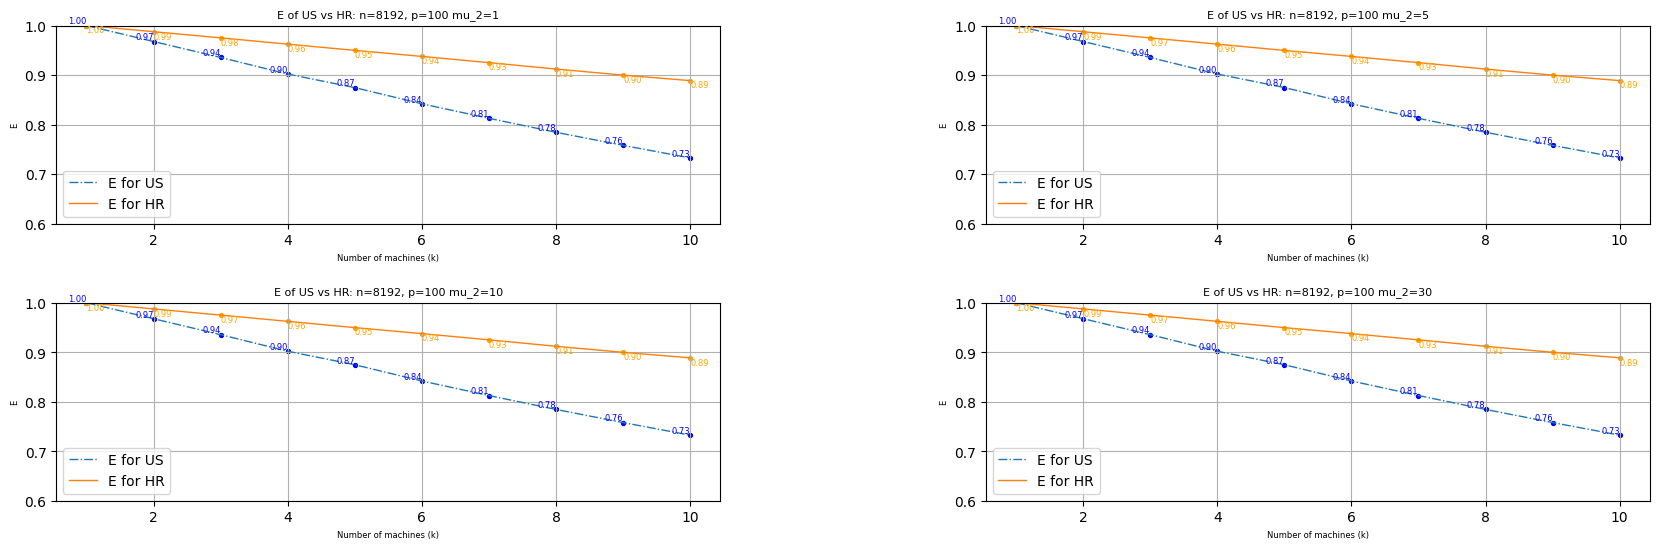

In [11]:
mu_2_list = [1,5,10,30]
# Create a figure
plt.figure()

# Add subplots (2 rows, 3 columns)
for i in range(1, 5):
    plt.subplot(2, 2, i)
    # Replace this with your plotting commands, e.g., plt.plot(...)
    plt.subplots_adjust(left=0.01, right=2.5, bottom=0.01, top=1, wspace=0.4, hspace=0.4)
    plot_mu_2_change(10,mu_2_list[i-1],8192,100,imbalance_factor=10,random_seed=42,delta=1)
    plt.ylim(0.6,1)
# Display the figure
plt.show()

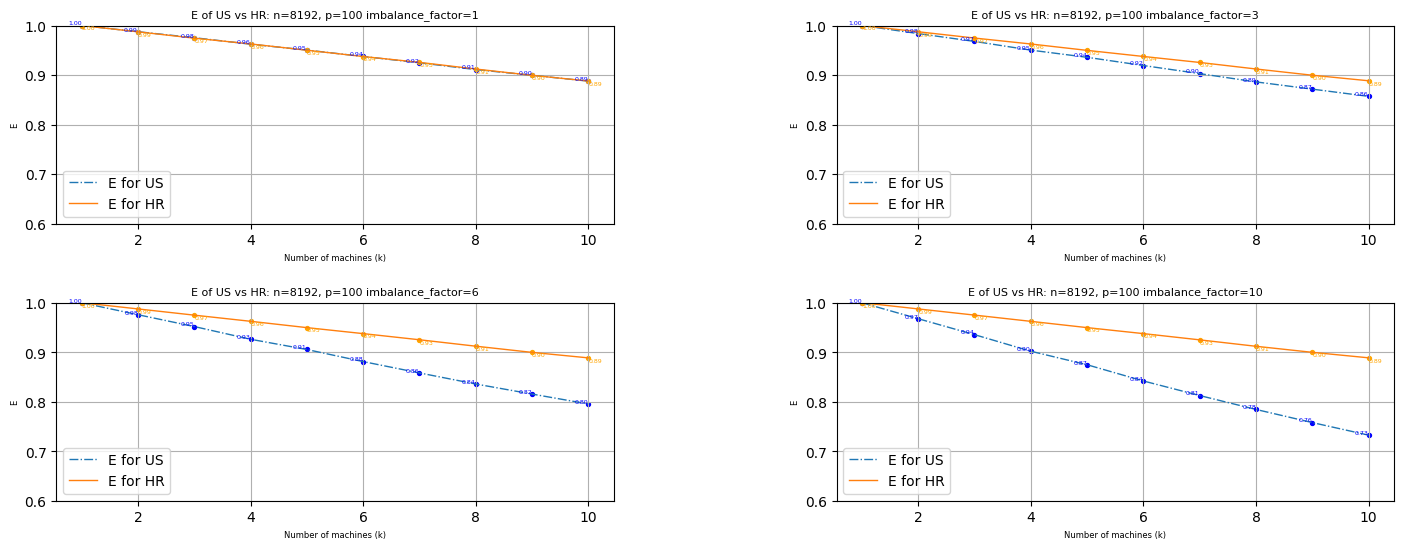

In [12]:
var_list = [1,3,6,10]
# Create a figure
plt.figure()

# Add subplots (2 rows, 3 columns)
for i in range(1, 5):
    plt.subplot(2, 2, i)
    # Replace this with your plotting commands, e.g., plt.plot(...)
    plt.subplots_adjust(left=0.01, right=2.1, bottom=0.01, top=1, wspace=0.4, hspace=0.4)
    plot_var_change(10,5,8192,100,imbalance_factor=var_list[i-1],random_seed=42,delta=1)# Display the figure
    plt.ylim(0.6,1)
plt.show()
plt.show()